# Benchmarking Python LAP Solvers

The scripts benchmark the performance of Python2/3 linear assignment problem (LAP) solvers for random cost matrices of different sizes.  These solvers are:

* **linear_sum_assignment** - a Python implementation of the Hungarian algorithm provided in SciPy
  * https://github.com/scipy/scipy/
* **munkres** - a Python implementation of the Hungarian algorithm provided by Brian Clapper
  * https://github.com/bmc/munkres
* **hungarian** - a wrapper to a C++ implementation Knuth's Hungarian algorithm provided by Harold Cooper
  * https://github.com/Hrldcpr/Hungarian
* **lap.lapjv** - a wrapper to a C++ implementation of Jonker-Volgenant algorithm provided by Tomas Kazmar
  * https://github.com/gatagat/lap
  In addition, these two solvers are added for Python3
* **lapjv.lapjv** - a wrapper to a C++ implementation of Jonker-Volgenant algorithm re-written for Python 3 and optimized to take advantage of AVX2 instruction sets by Vadim Markovtsev at src{d}.
  * Please see the [blog post here](https://blog.sourced.tech/post/lapjv/)
  * https://github.com/src-d/lapjv  
* **lapsolver** - implementation for dense matrices based on shortest path augmentation by Christoph Heindl.
  * Please note that Christioph has also done a [benchmark of LAP solvers](https://github.com/cheind/py-lapsolver/tree/master/lapsolver/benchmarks)
  * https://github.com/cheind/py-lapsolver      

They all formally have O(n<sup>3</sup>) complexity, but their performance differs substantially based on their implementation and the size of the matrix they are trying to solve. The solvers can be classified based on some unique characteristics.

|  Module                             | Python or C/C++/Cython  | Algorithm     |
|-------------------------------------|:-----------------------:|:--------------|
|scipy.optimize.linear_sum_assignment |          Python         | Hungarian     |
|munkres.Munkres                      |          Python         | Hungarian     |
|hungarian.lap                        |          C++            | Hungarian     |
|lap.lapjv                            |          C++            | Jonker-Volgenant     |
|lapjv.lapjv                          |          C++            | Jonker-Volgenant     |
|lapsolver.solve_dense                |          C++            | shortest augmenting path     |


In [16]:
from __future__ import print_function

import time
import argparse
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import inspect
import sys

## Load LAP solvers

`lapjv.lapjv` and `lapsolver.solve_dense` are only available for Python3

In [17]:
#LAP Solvers
import munkres
from scipy.optimize import linear_sum_assignment
from scipy.optimize import curve_fit
import hungarian
import lap

#If running Python3, benchmark all implementations
if sys.version_info[0] >= 3:
    import lapjv
    from lapsolver import solve_dense

## Invoke different LAP solvers


### lapJV

In [18]:
def run_lap_lapjv(matrix, printlowestcost):
    #print module name
    temp = inspect.stack()[0][3]
    method_name=temp[4:]
    print(" %s" % ( method_name ) )

    #start timing
    t_start = time.time()
    lowest_cost, row_ind, column_ind = lap.lapjv(matrix)
    t_end = time.time()
    #end timing

    #print minimum cost information with varying verbosity
    if printlowestcost:
        if verbose:
            lowest_cost = 0.00
            for i in range(len(row_ind)):
                lowest_cost += matrix[i, row_ind[i]]
                print("%18s %6d %5.3f" % ("      ", i ,lowest_cost))
        print("  %12s %s %5.3f" % (method_name, "minimum cost", lowest_cost))

    del row_ind
    del column_ind
    return t_end-t_start

### lapJV.lapJV

In [19]:
def run_lapjv_lapjv(matrix, printlowestcost):
    temp = inspect.stack()[0][3]
    method_name=temp[4:]
    print(" %s" % ( method_name ) )

    t_start = time.time()
    row_ind, column_ind, _ = lapjv.lapjv(matrix)
    t_end = time.time()

    if printlowestcost:
        lowest_cost = 0.00
        for i in range(len(row_ind)):
            lowest_cost += matrix[i, row_ind[i]]
            if verbose:
                print("%18s  %6d  %5.3f" % ("      ", i ,lowest_cost))
        print("  %12s %s %5.3f" % (method_name, "minimum cost", lowest_cost))

    del row_ind
    del column_ind
    return t_end-t_start

### lapsolver

In [20]:
def run_lapsolver(matrix, printlowestcost):
    temp = inspect.stack()[0][3]
    method_name=temp[4:]
    print(" %s" % ( method_name ) )

    t_start = time.time()
    row_ind, column_ind = solve_dense(matrix)
    t_end = time.time()

    if printlowestcost:
        lowest_cost = 0.00
        lowest_cost = matrix[row_ind, column_ind].sum()
        print("  %12s %s %5.3f" % (method_name, "minimum cost", lowest_cost))

    del row_ind
    del column_ind
    return t_end-t_start

### hungarian

In [21]:
def run_hungarian(matrix, printlowestcost):
    temp = inspect.stack()[0][3]
    method_name=temp[4:]
    print(" %s" % ( method_name ) )

    t_start = time.time()
    hung_mat = np.copy(matrix)
    row_ind, column_ind = hungarian.lap(hung_mat)
    t_end = time.time()

    if printlowestcost:
        lowest_cost = 0.00
        for i in range(len(row_ind)):
            lowest_cost += matrix[i, row_ind[i]]
            if verbose:
                print("%18s  %6d  %5.3f" % ("      ", i ,lowest_cost))
        print("  %12s %s %5.3f" % (method_name, "minimum cost", lowest_cost))

    del row_ind
    del column_ind
    del hung_mat
    return t_end-t_start

### scipy.linear_sum_assignment

In [22]:
def run_scipy(matrix, printlowestcost):
    temp = inspect.stack()[0][3]
    method_name=temp[4:]
    print(" %s" % ( method_name ) )

    t_start = time.time()
    row_ind, column_ind = linear_sum_assignment(matrix)
    t_end = time.time()

    if printlowestcost:
        lowest_cost = 0.00
        lowest_cost = matrix[row_ind, column_ind].sum()
        print("  %12s %s %5.3f" % (method_name, "minimum cost", lowest_cost))

    del row_ind
    del column_ind
    return t_end-t_start

### munkres

In [23]:
def run_munkres(matrix, printlowestcost):
    temp = inspect.stack()[0][3]
    method_name=temp[4:]
    print(" %s" % ( method_name ) )

    t_start = time.time()
    munk_mat = np.copy(matrix)
    m = munkres.Munkres()
    indices = m.compute(matrix)
    t_end = time.time()

    if printlowestcost:
        columns = [x[1] for x in indices]
        lowest_cost = 0.00
        for i in range(len(columns)):
            lowest_cost += munk_mat[i, columns[i]]
            if verbose:
                print("%18s  %6d  %5.3f" % ("      ", i ,lowest_cost))
        print("  %12s %s %5.3f" % (method_name, "minimum cost", lowest_cost))

    del indices
    del munk_mat
    return t_end-t_start

#### New method

One can add a function run_METHOD to get timing for that method

## Main function

The script  will produce the following:
- data of timing for LAP solving random cost matrices of dimensions 2<sup>min</sup> - 2<sup>max</sup>
- plot of timing for LAP solving random cost matrices of dimensions 2<sup>min</sup> - 2<sup>max</sup>

Instead of parsing arguments from the command line, it expects the following variables to be specified below

* **min** - minimum dimension of cost matrix to solve
    - The default is 8 (2<sup>3</sup> - 2<sup>3</sup>)
* **max** - maximum dimension of cost matrix to solve
    - The default is 4096 (2<sup>12</sup> - 2<sup>12</sup>)
* **ncyc** - number of times to solve cost matrices and average their timing
    - The default is 3 cycles')       
* **printcost** - Print the minimum cost.
    - The default is false, i.e. will not print the minimum cost
* **verbose** - Determines verbosity.
    - The default is minimal printing, i.e. not verbose
* **noplot** - Do not plot data.
    - The default is to save plot of the data in PNG format, but not open the plot GUI unless 'showplot=True'
* **showplot** - generate plot of data using matplotlib
    - The default is to save plot of the data in PNG format, but not open the plot GUI


In [24]:
if __name__ == "__main__":

 min = 8              # smallest dimension of square cost matrix to be solved
 max = 512           # largest dimension of square cost matrix to be solved
 ncyc = 1             # number of times to repeat benchmarks 
 printcost = False    # Print the minimum cost
 verbose = False      # Determines verbosity
 showplot = False     # Open matplotlib plot in a separate window         
 noplot = False       # Plot 

    
# METHODS being benchmarked -- Add new METHOD[S] here
if sys.version_info[0] >= 3:
    methods = ["lap_lapjv", "lapjv_lapjv", "lapsolver", "hungarian", "scipy", "munkres"]
else:
    methods = ["lap_lapjv", "hungarian","scipy", "munkres"]

min = int(np.floor(np.log2(min)))      # 2^min =  8x8 cost matrix
max = int(np.ceil(np.log2(max)))      # 2^max

ncyc = int(ncyc)                      # number of cycle

### LIMITS - add limit for new METHOD[S] here
The size of the matrix to be solved is limited to 2^{limit['method']} for each method to ensure quick termination of the benchmarking exercise. Munkres and Scipy are considerably slower, making it necessary to limit them to smaller matrices

In [25]:
limit = {}
limit['munkres'] = 7
limit['scipy'] = 9
limit['hungarian'] = max
limit['lap_lapjv'] = max
limit['lapjv_lapjv'] = max
limit['lapsolver'] = max
print("Solving matrices of sizes up to 2^{n} where n is " + str(limit))


Solving matrices of sizes up to 2^{n} where n is {'lap_lapjv': 9, 'scipy': 9, 'lapjv_lapjv': 9, 'munkres': 7, 'lapsolver': 9, 'hungarian': 9}


In [26]:
# arrays to store data
t_methods = ["t_" + i for i in methods]
for i in range(len(methods)):
    t_methods[i] = np.empty((0, 2), float)
label_methods = ["label_" + i for i in methods]
run_methods = ["run_" + i for i in methods]

base = 2               # will build matrices of size base^n and solve them

In [27]:
for i in range(min, max):
    matrix_size = pow(base, i)
    print(("\n" + str(matrix_size) + " x " + str(matrix_size) + " ... "))
    methods_data = np.zeros(len(methods), float)

    # Generate n_cyc random matrices and solve them using different methods
    for j in range(ncyc):
        cost_matrix = matrix_size * \
            np.random.random((matrix_size, matrix_size))
        print("Cycle ", (str(j) + " "))
        # print("\n")
        # print(cost_matrix)
        for method in range(len(methods)):
            # print '%20s\t' %(methods[method])
            if methods[method] == 'munkres' and i <= limit[methods[method]]:
                methods_data[method] += run_munkres(
                    cost_matrix, printcost)
            elif methods[method] == 'scipy' and i <= limit[methods[method]]:
                real_time = run_scipy(cost_matrix, printcost)
                methods_data[method] += real_time
            elif methods[method] == 'hungarian' and i <= limit[methods[method]]:
                methods_data[method] += run_hungarian(
                    cost_matrix, printcost)
            elif methods[method] == 'lap_lapjv' and i <= limit[methods[method]]:
                methods_data[method] += run_lap_lapjv(
                    cost_matrix, printcost)
            elif methods[method] == 'lapjv_lapjv' and i <= limit[methods[method]]:
                methods_data[method] += run_lapjv_lapjv(
                    cost_matrix, printcost)
            elif methods[method] == 'lapsolver' and i <= limit[methods[method]]:
                methods_data[method] += run_lapsolver(
                    cost_matrix, printcost)
                # If you want to benchmark a new METHOD, add another ELIF statement here
            else:
                pass
            
    # average the timing information from n_cyc cycles
    for method in range(len(methods)):
        if methods_data[method] != 0:   # to make sure there is timing information
            t_methods[method] = np.append(t_methods[method],
                                          np.array([[matrix_size, methods_data[method]/ncyc]]), axis=0)


8 x 8 ... 
Cycle  0 
 lap_lapjv
 lapjv_lapjv
 lapsolver
 hungarian
 scipy
 munkres

16 x 16 ... 
Cycle  0 
 lap_lapjv
 lapjv_lapjv
 lapsolver
 hungarian
 scipy
 munkres

32 x 32 ... 
Cycle  0 
 lap_lapjv
 lapjv_lapjv
 lapsolver
 hungarian
 scipy
 munkres

64 x 64 ... 
Cycle  0 
 lap_lapjv
 lapjv_lapjv
 lapsolver
 hungarian
 scipy
 munkres

128 x 128 ... 
Cycle  0 
 lap_lapjv
 lapjv_lapjv
 lapsolver
 hungarian
 scipy
 munkres

256 x 256 ... 
Cycle  0 
 lap_lapjv
 lapjv_lapjv
 lapsolver
 hungarian
 scipy


### Print timing information to screen

In [28]:
dimensions = t_methods[0][:, [0]]
dimensions = dimensions.flatten()
print("\n")
print("  %12s " % ("Matrix_dims"), end=" ")
np.set_printoptions(suppress=True, precision=5, linewidth=100)
for i in range(len(dimensions)):
    print('%6d ' % (dimensions[i]), end=" ")
print(" ")

np.set_printoptions(suppress=True, precision=5, linewidth=100)
for method in range(len(methods)):
    print('%12s ' % (methods[method]), end=" ")
    timings = t_methods[method][:, [1]]
    timings = timings.flatten()
    print(timings)



   Matrix_dims       8      16      32      64     128     256   
   lap_lapjv  [0.00006 0.00005 0.00006 0.00007 0.00023 0.00061]
 lapjv_lapjv  [0.00002 0.00002 0.00004 0.00004 0.00016 0.00044]
   lapsolver  [0.00003 0.00002 0.00004 0.0001  0.00051 0.00221]
   hungarian  [0.00001 0.00002 0.00005 0.00013 0.00078 0.00538]
       scipy  [0.00065 0.00144 0.0042  0.01578 0.07019 0.56042]
     munkres  [0.00064 0.00544 0.05589 0.47776 3.95491]


### Generate a plot
Unless 'noplot=True'

Figure saved to file timing-LAPs-py3-8-512.png


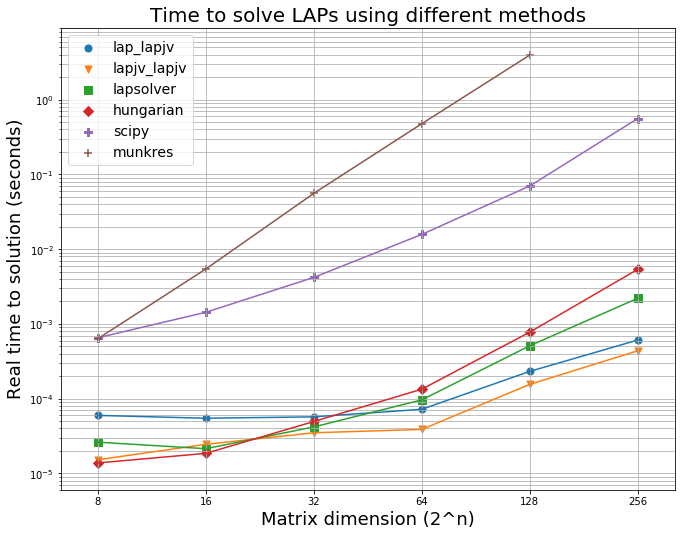

In [29]:
if noplot:
    pass
else:
    markers = []
    markers = ['o', 'v', 's', 'D', 'P', '+', '*', '0', '1', '2']
    marker_size = [50]
    fig, ax = plt.subplots()
    for method in range(len(methods)):
        plt.scatter(t_methods[method][:, [0]], t_methods[method][:, [1]],
                    s=marker_size, label=methods[method], marker=markers[method])
        plt.loglog(t_methods[method][:, [0]], t_methods[method][:, [1]],
                   basex=2, basey=10)

    plt.grid(True, which="both")
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    plt.xlabel('Matrix dimension (2^n)', fontsize=18)
    plt.ylabel('Real time to solution (seconds)', fontsize=18)
    plt.title('Time to solve LAPs using different methods', fontsize=20)
    plt.legend(fontsize=14)
    fig_filename = "timing-LAPs-py3-" + \
        str(pow(2, min)) + "-" + str(pow(2, max)) + ".png"
    print("Figure saved to file %18s" % (fig_filename))
    fig.set_size_inches(11, 8.5)
    plt.savefig(fig_filename, bbox_inches='tight', dpi=150)
    if showplot:
        plt.show()